In [ ]:
import tensorflow as tf
import numpy as np
import re

# Function to sanitize file names
def sanitize_filename(name):
    # Replace invalid characters (e.g., '/') with underscores
    return re.sub(r'[^a-zA-Z0-9_.-]', '_', name)

# Load the TensorFlow Lite model
model_path = "/content/trained.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)

# Allocate tensors
interpreter.allocate_tensors()

# Get details of all tensors
tensor_details = interpreter.get_tensor_details()

# Extract weights and biases
weights = {}
biases = {}
for tensor in tensor_details:
    tensor_name = tensor['name']
    try:
        # Attempt to access the tensor data
        tensor_data = interpreter.get_tensor(tensor['index'])
        print(f"Tensor: {tensor_name}, Shape: {tensor_data.shape}, Dtype: {tensor_data.dtype}")

        # Check if the tensor is a weight or bias
        if 'MatMul' in tensor_name and 'BiasAdd' not in tensor_name:  # Weights
            weights[tensor_name] = tensor_data
        elif 'BiasAdd' in tensor_name:  # Biases
            biases[tensor_name] = tensor_data
    except ValueError as e:
        print(f"Skipping tensor {tensor_name}: {e}")

# Print weights and biases
print("\nWeights:")
for name, data in weights.items():
    print(f"{name}: Shape {data.shape}, Dtype {data.dtype}")

print("\nBiases:")
for name, data in biases.items():
    print(f"{name}: Shape {data.shape}, Dtype {data.dtype}")

# Save weights and biases to binary files
for name, data in weights.items():
    sanitized_name = sanitize_filename(name)
    print(f"Attempting to save weights to {sanitized_name}.bin")
    data.tofile(f"{sanitized_name}.bin")
    print(f"Saved weights to {sanitized_name}.bin")

for name, data in biases.items():
    sanitized_name = sanitize_filename(name)
    print(f"Attempting to save biases to {sanitized_name}.bin")
    data.tofile(f"{sanitized_name}.bin")
    print(f"Saved biases to {sanitized_name}.bin")

Tensor: serving_default_x:0, Shape: (1, 1600), Dtype: int8
Tensor: sequential/y_pred/BiasAdd/ReadVariableOp, Shape: (4,), Dtype: int32
Tensor: sequential/y_pred/MatMul, Shape: (4, 256), Dtype: int8
Tensor: sequential/dense_2/BiasAdd/ReadVariableOp, Shape: (256,), Dtype: int32
Tensor: sequential/dense_2/MatMul, Shape: (256, 256), Dtype: int8
Tensor: sequential/dense_1/BiasAdd/ReadVariableOp, Shape: (256,), Dtype: int32
Tensor: sequential/dense_1/MatMul, Shape: (256, 256), Dtype: int8
Tensor: sequential/dense/BiasAdd/ReadVariableOp, Shape: (256,), Dtype: int32
Tensor: sequential/dense/MatMul, Shape: (256, 1600), Dtype: int8
Skipping tensor sequential/dense/MatMul;sequential/dense/Relu;sequential/dense/BiasAdd: Tensor data is null. Run allocate_tensors() first
Skipping tensor sequential/dense_1/MatMul;sequential/dense_1/Relu;sequential/dense_1/BiasAdd: Tensor data is null. Run allocate_tensors() first
Skipping tensor sequential/dense_2/MatMul;sequential/dense_2/Relu;sequential/dense_2/Bia

In [ ]:
import tensorflow as tf

# Load the TensorFlow Lite model
try:
    interpreter = tf.lite.Interpreter(model_path="/content/trained.tflite")
    print("Model loaded successfully.")
except ValueError as e:
    print("Error loading the model:", e)


tensor_details = interpreter.get_tensor_details()
for tensor in tensor_details:
    print(f"Name: {tensor['name']}, Index: {tensor['index']}, Shape: {tensor['shape']}, Type: {tensor['dtype']}")

Model loaded successfully.
Name: serving_default_x:0, Index: 0, Shape: [   1 1600], Type: <class 'numpy.int8'>
Name: sequential/y_pred/BiasAdd/ReadVariableOp, Index: 1, Shape: [4], Type: <class 'numpy.int32'>
Name: sequential/y_pred/MatMul, Index: 2, Shape: [  4 256], Type: <class 'numpy.int8'>
Name: sequential/dense_2/BiasAdd/ReadVariableOp, Index: 3, Shape: [256], Type: <class 'numpy.int32'>
Name: sequential/dense_2/MatMul, Index: 4, Shape: [256 256], Type: <class 'numpy.int8'>
Name: sequential/dense_1/BiasAdd/ReadVariableOp, Index: 5, Shape: [256], Type: <class 'numpy.int32'>
Name: sequential/dense_1/MatMul, Index: 6, Shape: [256 256], Type: <class 'numpy.int8'>
Name: sequential/dense/BiasAdd/ReadVariableOp, Index: 7, Shape: [256], Type: <class 'numpy.int32'>
Name: sequential/dense/MatMul, Index: 8, Shape: [ 256 1600], Type: <class 'numpy.int8'>
Name: sequential/dense/MatMul;sequential/dense/Relu;sequential/dense/BiasAdd, Index: 9, Shape: [  1 256], Type: <class 'numpy.int8'>
Name: 

In [ ]:
import tensorflow as tf
import numpy as np
import re

# Function to sanitize file names
def sanitize_filename(name):
    # Replace invalid characters (e.g., '/') with underscores
    return re.sub(r'[^a-zA-Z0-9_.-]', '_', name)

# Function to quantize data to 4-bit
def quantize_to_4bit(data, signed=True):
    if signed:
        # Map data to the range [-8, 7] for signed 4-bit
        min_val, max_val = -8, 7
    else:
        # Map data to the range [0, 15] for unsigned 4-bit
        min_val, max_val = 0, 15

    # Normalize data to the 4-bit range
    data = np.clip(data, min_val, max_val)
    data = np.round(data).astype(np.int8)  # Use int8 for storage

    return data

# Function to pack 4-bit values into bytes
def pack_4bit_to_bytes(data):
    # Ensure the data has an even number of elements
    if len(data) % 2 != 0:
        data = np.append(data, 0)  # Pad with 0 if necessary

    # Reshape the data into pairs of 4-bit values
    data = data.reshape(-1, 2)

    # Pack each pair into a single byte
    packed_data = (data[:, 0] << 4) | (data[:, 1] & 0x0F)
    return packed_data.astype(np.uint8)

# Load the TensorFlow Lite model
model_path = "/content/trained.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)

# Allocate tensors
interpreter.allocate_tensors()

# Get details of all tensors
tensor_details = interpreter.get_tensor_details()

# Extract weights and biases
weights = {}
biases = {}
for tensor in tensor_details:
    tensor_name = tensor['name']
    try:
        # Attempt to access the tensor data
        tensor_data = interpreter.get_tensor(tensor['index'])
        print(f"Tensor: {tensor_name}, Shape: {tensor_data.shape}, Dtype: {tensor_data.dtype}")

        # Check if the tensor is a weight or bias
        if 'MatMul' in tensor_name and 'BiasAdd' not in tensor_name:  # Weights
            weights[tensor_name] = tensor_data
        elif 'BiasAdd' in tensor_name:  # Biases
            biases[tensor_name] = tensor_data
    except ValueError as e:
        print(f"Skipping tensor {tensor_name}: {e}")

# Print weights and biases
print("\nWeights:")
for name, data in weights.items():
    print(f"{name}: Shape {data.shape}, Dtype {data.dtype}")

print("\nBiases:")
for name, data in biases.items():
    print(f"{name}: Shape {data.shape}, Dtype {data.dtype}")

# Save weights (4-bit packed) and biases (int16_t) to binary files
for name, data in weights.items():
    sanitized_name = sanitize_filename(name)
    print(f"Attempting to save weights to {sanitized_name}.bin")

    # Quantize to 4-bit
    quantized_data = quantize_to_4bit(data.flatten(), signed=True)

    # Pack 4-bit values into bytes
    packed_data = pack_4bit_to_bytes(quantized_data)

    # Save to binary file
    packed_data.tofile(f"{sanitized_name}.bin")
    print(f"Saved weights to {sanitized_name}.bin")

for name, data in biases.items():
    sanitized_name = sanitize_filename(name)
    print(f"Attempting to save biases to {sanitized_name}.bin")

    # Flatten and convert biases to int16_t
    int16_data = data.flatten().astype(np.int16)

    # Save to binary file
    int16_data.tofile(f"{sanitized_name}.bin")
    print(f"Saved biases to {sanitized_name}.bin")

Tensor: serving_default_x:0, Shape: (1, 1600), Dtype: int8
Tensor: sequential/y_pred/BiasAdd/ReadVariableOp, Shape: (4,), Dtype: int32
Tensor: sequential/y_pred/MatMul, Shape: (4, 256), Dtype: int8
Tensor: sequential/dense_2/BiasAdd/ReadVariableOp, Shape: (256,), Dtype: int32
Tensor: sequential/dense_2/MatMul, Shape: (256, 256), Dtype: int8
Tensor: sequential/dense_1/BiasAdd/ReadVariableOp, Shape: (256,), Dtype: int32
Tensor: sequential/dense_1/MatMul, Shape: (256, 256), Dtype: int8
Tensor: sequential/dense/BiasAdd/ReadVariableOp, Shape: (256,), Dtype: int32
Tensor: sequential/dense/MatMul, Shape: (256, 1600), Dtype: int8
Skipping tensor sequential/dense/MatMul;sequential/dense/Relu;sequential/dense/BiasAdd: Tensor data is null. Run allocate_tensors() first
Skipping tensor sequential/dense_1/MatMul;sequential/dense_1/Relu;sequential/dense_1/BiasAdd: Tensor data is null. Run allocate_tensors() first
Skipping tensor sequential/dense_2/MatMul;sequential/dense_2/Relu;sequential/dense_2/Bia

In [ ]:
import tensorflow as tf

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="/content/trained.tflite")
interpreter.allocate_tensors()

# Get tensor details
tensor_details = interpreter.get_tensor_details()

# Print quantization parameters for each tensor
for tensor in tensor_details:
    print(f"Tensor: {tensor['name']}")
    print(f"  Shape: {tensor['shape']}")
    print(f"  Dtype: {tensor['dtype']}")
    if 'quantization' in tensor:
        scale = tensor['quantization'][0]
        zero_point = tensor['quantization'][1]
        print(f"  Scale: {scale}")
        print(f"  Zero Point: {zero_point}")
    print()

Tensor: serving_default_x:0
  Shape: [   1 1600]
  Dtype: <class 'numpy.int8'>
  Scale: 0.003507965710014105
  Zero Point: -128

Tensor: sequential/y_pred/BiasAdd/ReadVariableOp
  Shape: [4]
  Dtype: <class 'numpy.int32'>
  Scale: 6.192741420818493e-05
  Zero Point: 0

Tensor: sequential/y_pred/MatMul
  Shape: [  4 256]
  Dtype: <class 'numpy.int8'>
  Scale: 0.002070141490548849
  Zero Point: 0

Tensor: sequential/dense_2/BiasAdd/ReadVariableOp
  Shape: [256]
  Dtype: <class 'numpy.int32'>
  Scale: 2.5274990548496135e-05
  Zero Point: 0

Tensor: sequential/dense_2/MatMul
  Shape: [256 256]
  Dtype: <class 'numpy.int8'>
  Scale: 0.0013865033397451043
  Zero Point: 0

Tensor: sequential/dense_1/BiasAdd/ReadVariableOp
  Shape: [256]
  Dtype: <class 'numpy.int32'>
  Scale: 3.346194716868922e-05
  Zero Point: 0

Tensor: sequential/dense_1/MatMul
  Shape: [256 256]
  Dtype: <class 'numpy.int8'>
  Scale: 0.0019459010800346732
  Zero Point: 0

Tensor: sequential/dense/BiasAdd/ReadVariableOp
  

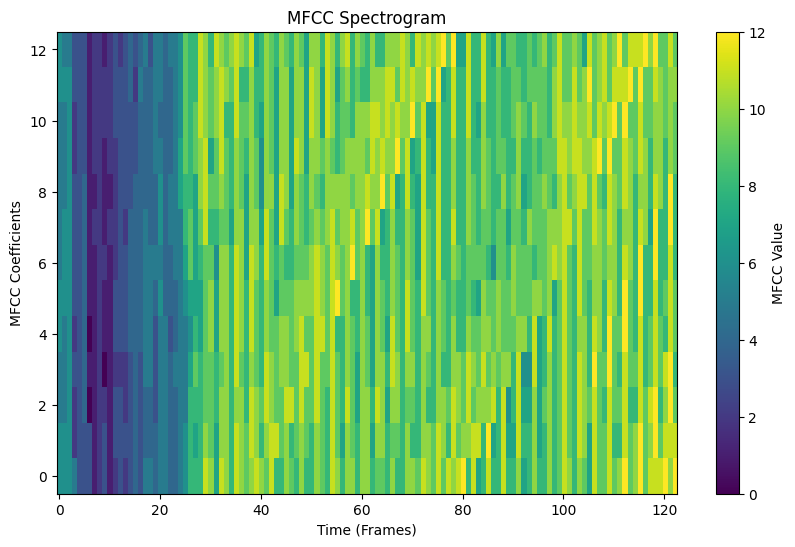

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Insert your MFCC values here
mfcc_values = [
 6, 6, 5, 5, 6, 6, 5, 5, 5, 5, 5, 6, 6, 6, 6, 5, 5, 5, 6, 6, 6, 5, 5, 5, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 2, 2, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 0, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 4, 5, 4, 4, 5, 5, 5, 5, 5, 4, 4, 4, 4, 5, 5, 4, 4, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 4, 4, 3, 3, 3, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 6, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 5, 5, 4, 4, 4, 5, 4, 4, 4, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 6, 6, 6, 6, 6, 5, 5, 5, 6, 7, 8, 8, 9, 9, 9, 9, 8, 8, 8, 7, 6, 7, 9, 9, 8, 8, 8, 8, 8, 8, 7, 8, 9, 8, 7, 7, 7, 7, 9, 9, 8, 8, 8, 8, 8, 8, 7, 7, 8, 9, 10, 10, 11, 11, 11, 11, 10, 9, 9, 9, 9, 9, 11, 11, 11, 10, 10, 10, 10, 9, 9, 9, 10, 10, 9, 8, 9, 7, 9, 9, 8, 7, 7, 8, 8, 7, 7, 6, 8, 9, 9, 10, 10, 11, 11, 10, 10, 9, 10, 10, 10, 9, 10, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 8, 10, 9, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 9, 10, 11, 11, 10, 11, 11, 11, 11, 10, 10, 10, 11, 11, 11, 10, 10, 10, 9, 10, 10, 10, 10, 9, 9, 9, 8, 10, 9, 9, 8, 8, 8, 8, 7, 7, 7, 8, 9, 8, 9, 10, 11, 11, 10, 11, 11, 11, 10, 10, 10, 10, 10, 11, 11, 10, 10, 9, 9, 9, 10, 10, 9, 9, 8, 8, 7, 10, 8, 9, 8, 8, 8, 8, 7, 6, 6, 7, 8, 8, 9, 10, 11, 11, 10, 10, 11, 11, 10, 10, 10, 10, 10, 11, 11, 10, 10, 9, 9, 9, 9, 10, 9, 9, 9, 9, 8, 11, 9, 9, 9, 7, 8, 7, 7, 7, 7, 7, 8, 8, 9, 9, 10, 10, 9, 9, 11, 11, 10, 10, 10, 10, 10, 10, 11, 10, 10, 9, 8, 9, 10, 10, 10, 10, 9, 9, 8, 11, 9, 9, 9, 8, 8, 7, 7, 7, 7, 8, 8, 9, 9, 9, 10, 10, 9, 10, 10, 11, 10, 10, 10, 10, 10, 11, 11, 11, 10, 9, 9, 9, 10, 10, 10, 9, 8, 9, 9, 11, 9, 10, 9, 8, 8, 7, 7, 7, 7, 8, 8, 9, 9, 9, 10, 10, 9, 10, 10, 11, 11, 10, 10, 10, 11, 11, 11, 11, 11, 10, 9, 10, 10, 10, 10, 9, 9, 9, 9, 11, 10, 10, 9, 8, 9, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 9, 10, 10, 10, 10, 9, 9, 9, 8, 12, 10, 9, 10, 8, 8, 7, 8, 8, 7, 8, 8, 8, 9, 9, 10, 10, 9, 9, 9, 10, 10, 10, 11, 10, 10, 10, 10, 10, 10, 10, 9, 10, 11, 10, 9, 9, 9, 9, 8, 12, 11, 9, 10, 8, 8, 8, 8, 8, 7, 7, 8, 8, 9, 9, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 9, 10, 10, 10, 9, 9, 8, 8, 12, 11, 9, 10, 8, 8, 8, 7, 8, 7, 7, 7, 7, 9, 10, 11, 11, 10, 10, 9, 10, 11, 10, 10, 10, 10, 11, 10, 10, 11, 10, 8, 9, 10, 10, 10, 9, 9, 8, 7, 12, 11, 10, 10, 8, 8, 8, 7, 8, 7, 8, 8, 8, 9, 10, 11, 11, 10, 10, 9, 10, 11, 11, 10, 10, 10, 11, 10, 10, 11, 10, 8, 9, 10, 10, 9, 9, 9, 8, 7, 12, 11, 9, 10, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 10, 11, 11, 10, 10, 9, 10, 11, 11, 10, 10, 11, 11, 10, 10, 10, 10, 8, 9, 10, 9, 9, 9, 9, 8, 7, 12, 11, 8, 9, 8, 8, 8, 8, 8, 7, 7, 7, 8, 9, 10, 11, 11, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 8, 9, 10, 9, 9, 9, 8, 8, 7, 12, 11, 9, 9, 8, 8, 8, 8, 8, 8, 8, 7, 7, 9, 10, 11, 11, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 11, 9, 10, 10, 8, 9, 9, 8, 8, 8, 8, 8, 7, 12, 11, 8, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 10, 11, 11, 10, 10, 9, 10, 11, 10, 10, 11, 11, 12, 11, 9, 10, 10, 8, 8, 9, 8, 8, 8, 8, 8, 7, 12, 10, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 10, 11, 11, 10, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11, 9, 10, 9, 8, 9, 9, 9, 8, 8, 8, 8, 7, 11, 10, 9, 9, 7, 9, 8, 8, 8, 7, 8, 8, 8, 8, 10, 11, 10, 10, 9, 9, 10, 10, 10, 11, 11, 11, 12, 10, 9, 10, 9, 8, 9, 9, 9, 8, 8, 8, 8, 7, 11, 10, 9, 9, 6, 8, 8, 8, 8, 8, 7, 8, 8, 8, 9, 10, 10, 9, 9, 8, 9, 9, 9, 10, 11, 11, 11, 10, 9, 9, 9, 9, 10, 9, 8, 8, 7, 8, 7, 6, 10, 9, 9, 8, 7, 8, 8, 8, 8, 9, 8, 7, 8, 8, 9, 10, 10, 9, 9, 8, 9, 9, 9, 10, 11, 11, 11, 10, 9, 9, 9, 10, 10, 10, 9, 8, 7, 8, 7, 6, 10, 9, 9, 8, 7, 8, 9, 8, 8, 8, 8, 7, 6, 8, 9, 9, 10, 8, 8, 8, 9, 9, 10, 10, 10, 11, 11, 10, 8, 9, 9, 9, 10, 9, 8, 8, 7, 7, 7, 7, 10, 9, 9, 9, 8, 9, 9, 9, 8, 8, 9, 8, 8, 9, 9, 9, 10, 9, 9, 9, 10, 10, 10, 10, 10, 11, 10, 10, 10, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 7, 11, 10, 8, 9, 10, 10, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 9, 9, 10, 9, 9, 9, 9, 9, 9, 11, 9, 10, 10, 9, 9, 8, 8, 8, 8, 8, 8, 8, 9, 10, 11, 11, 11, 10, 10, 11, 11, 11, 10, 11, 11, 11, 11, 11, 10, 9, 9, 9, 10, 10, 10, 10, 9, 9, 9, 11, 10, 10, 10, 7, 7, 7, 9, 8, 8, 8, 9, 9, 9, 10, 11, 12, 11, 11, 11, 11, 12, 11, 10, 10, 11, 11, 11, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 9, 12, 11, 10, 10, 9, 9, 8, 9, 8, 8, 9, 9, 8, 9, 10, 11, 11, 11, 11, 11, 12, 12, 11, 10, 11, 11, 12, 11, 9, 9, 9, 8, 9, 9, 9, 10, 10, 10, 10, 9, 12, 11, 10, 10, 8, 9, 8, 9, 8, 8, 8, 9, 9, 9, 11, 12, 12, 11, 11, 11, 12, 12, 11, 10, 11, 11, 12, 11, 9, 9, 9, 8, 9, 9, 9, 10, 10, 10, 10, 9, 12, 11, 10, 10, 8, 9, 8, 8, 8, 8, 8, 9, 9, 9, 11, 12, 12, 11, 11, 11, 12, 12, 11, 10, 11, 11, 12, 11, 9, 9, 9, 8, 8, 8, 8, 10, 10, 10, 9, 9, 12, 11, 10, 11, 9, 9, 8, 8, 7, 8, 8, 9, 9, 10, 11, 12, 12, 11, 11, 11, 12, 12, 11, 10, 10, 11, 12, 11, 9, 8, 9, 9, 8, 8, 8, 10, 10, 10, 10, 9, 12, 11, 10, 11, 8, 9, 8, 8, 8, 8, 9, 9, 9, 10, 11, 12, 12, 11, 11, 11, 12, 12, 10, 10, 10, 11, 12, 11, 9, 8, 9, 9, 8, 8, 8, 9, 9, 10, 9
]

# Reshape the MFCC values into a 2D array (frames x coefficients)
num_frames = len(mfcc_values) // 13  # 13 MFCC coefficients per frame
mfcc_matrix = np.array(mfcc_values).reshape(num_frames, 13)

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(mfcc_matrix.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='MFCC Value')
plt.xlabel('Time (Frames)')
plt.ylabel('MFCC Coefficients')
plt.title('MFCC Spectrogram')
plt.show()


In [10]:
import tensorflow as tf
import numpy as np

def extract_model_info(model_path):
    # Load the TensorFlow Lite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    print("===== Input Details =====")
    for detail in input_details:
        print(f"Name: {detail['name']}")
        print(f"Shape: {detail['shape']}")
        print(f"Data Type: {detail['dtype']}")
        print(f"Index: {detail['index']}")
        print()

    print("===== Output Details =====")
    for detail in output_details:
        print(f"Name: {detail['name']}")
        print(f"Shape: {detail['shape']}")
        print(f"Data Type: {detail['dtype']}")
        print(f"Index: {detail['index']}")
        print()

    # Get all tensor details (including weights and biases)
    print("===== Tensor Details =====")
    for detail in interpreter.get_tensor_details():
        print(f"Tensor Name: {detail['name']}")
        print(f"Tensor Index: {detail['index']}")
        print(f"Shape: {detail['shape']}")
        print(f"Data Type: {detail['dtype']}")

        # Extract tensor data (weights/biases)
        tensor_data = interpreter.get_tensor(detail['index'])
        print("Tensor Data:")
        print(tensor_data)
        print()

def main():
    # Path to your model.bin file
    model_path = "ndp101_model.bin"

    # Extract and print model information
    extract_model_info(model_path)

if __name__ == "__main__":
    main()

ValueError: Model provided has model identifier '

In [1]:
pip install edgeimpulse

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.3.0
    Uninstalling urllib3-2.3.0:
      Successfully uninstalled urllib3-2.3.0
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.10.6
    Uninstalling pydantic-2.10.6:
      Successfully

In [3]:
import edgeimpulse as ei

# Change to an API key from your Edge Impulse project
ei.API_KEY = "ei_de3308a0e1ed356f3885815b652b49c48220c2c664c4d0cb4a6b0e50942c0b35"

# Print inference estimates
result = ei.model.profile(model="/content/trained.tflite")
result.summary()

Performance on device types:
{
    "variant": "int8",
    "lowEndMcu": {
        "description": "Estimate for a Cortex-M0+ or similar, running at 40MHz",
        "timePerInferenceMs": 70,
        "memory": {
            "tflite": {
                "ram": 5424,
                "rom": 574136
            },
            "eon": {
                "ram": 3304,
                "rom": 558328
            }
        },
        "supported": true
    },
    "highEndMcu": {
        "description": "Estimate for a Cortex-M7 or other high-end MCU/DSP, running at 240MHz",
        "timePerInferenceMs": 2,
        "memory": {
            "tflite": {
                "ram": 5596,
                "rom": 580840
            },
            "eon": {
                "ram": 3432,
                "rom": 560280
            }
        },
        "supported": true
    },
    "highEndMcuPlusAccelerator": {
        "description": "Estimate for an MCU plus neural network accelerator",
        "timePerInferenceMs": 1,
     